In [22]:
import networkx as nx
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
from collections import Counter

### Question 2b: loading GML files into NetworkX

In [11]:
# Read GML files into nx graphs
G_berlin = nx.read_gml('../data/tsp/berlin52.gml')
G_brazil = nx.read_gml('../data/tsp/brazil58.gml')
G_brg = nx.read_gml('../data/tsp/brg180.gml')
G_gr = nx.read_gml('../data/tsp/gr229.gml')
G_pr = nx.read_gml('../data/tsp/pr439.gml')

# Add name attributes to graphs for easy identification
G_berlin.graph['name'] = 'Berlin'
G_brazil.graph['name'] = 'Brazil'
G_brg.graph['name'] = 'Brg'
G_gr.graph['name'] = 'Gr'
G_pr.graph['name'] = 'Pr'

In [12]:
# Print the number of nodes and edges in each graph
tsp_graphs = [G_berlin, G_brazil, G_brg, G_gr, G_pr]
for g in tsp_graphs:
    print(g.graph['name'])
    print('  Number of nodes: ' + str(g.number_of_nodes()))
    print('  Number of edges: ' + str(g.number_of_edges()))

Berlin
  Number of nodes: 52
  Number of edges: 2652
Brazil
  Number of nodes: 58
  Number of edges: 3306
Brg
  Number of nodes: 180
  Number of edges: 32220
Gr
  Number of nodes: 229
  Number of edges: 52212
Pr
  Number of nodes: 439
  Number of edges: 192282


### Question 2d: working with the TSP solver code

Before executing the code for this question, make sure you are using the ```/home/waldrip.c/.conda/envs/my_custom_env``` custom environment. Alternatively, you can use ```pip install acopy``` in your conda environment.

In [13]:
import acopy

In [14]:
# ACOpy expects the weights on edges to be saved as an attribute 'weight'
# The graphs we were provided have weights saved as 'cost'
# Change the 'cost' attribute to 'weight' on each edge in all graphs
for g in tsp_graphs:
    for _, _, data in g.edges(data=True):
        data['weight'] = data.pop('cost')

In [16]:
# An example usage of the ACOpy solver. See https://acopy.readthedocs.io/en/latest/usage.html for information on the objects and parameters.

solver = acopy.Solver(rho=.03, q=1)
colony = acopy.Colony(alpha=1, beta=3)

tour = solver.solve(G_berlin, colony, limit=100)

tour.cost

8353.480727170407

### Question 2e: comparing solver performance with provided graphs

Note: The solver was (understandably) very slow on the last couple of graphs when I tried to run it with default parameters. For the purposes of this 
question and for the sake of time, I opted to solve the graphs with very few iterations of the algorithm (the ```solver_limit``` parameter) and only 3 runs of the solver on each graph (the ```num_runs``` parameter). This method was still effective for seeing performance with growing graph sizes. 

In [18]:
def tsp_solve(graphs: list[nx.Graph], 
                     num_runs :int, 
                     solver: acopy.Solver,
                     colony :acopy.Colony,
                     solver_limit: int = 100) -> dict[nx.Graph, (float, acopy.Solution)]:
    '''
    For a list of NetworkX graphs, returns each graph's best TSP solution under the user-provided parameters. Also returns the average duration 
    to compute a solution over multiple solves.
    
    Inputs
    ------
    graphs: list of Networkx graphs (must have edge attribute 'weight')
    num_runs: how many times to run the solver
    solver: ACOpy solver
    colony: ACOpy colony
    solver_limit: number of iterations the solver should perform before returning a solution. Default: 100.
    
    Outputs
    -------
    results: dictionary of graph -> (average duration, best discovered solution) 
    '''
    results = {}
    for g in graphs:
        print('Graph: ' + str(g.graph['name']))
        total_duration = 0
        best_soln = None
        for i in range(num_runs):
            print('  iteration #' + str(i))
            soln = solver.solve(g, colony, limit=solver_limit)
            if (best_soln is None or (soln is not None and soln.cost < best_soln.cost)):
                best_soln = soln
            total_duration += timer.duration
        avg_duration = total_duration / num_runs
        results[g] = (avg_duration, best_soln)

    return results

# running the solver on provided graphs
solver = acopy.Solver(rho=.03, q=1, top=10)
timer = acopy.plugins.Timer() 
solver.add_plugin(timer) # store the time it takes to solve
colony = acopy.Colony(alpha=1, beta=3)

results = tsp_solve(tsp_graphs, 3, solver, colony, 5)

Graph: Berlin
  iteration #0
  iteration #1
  iteration #2
Graph: Brazil
  iteration #0
  iteration #1
  iteration #2
Graph: Brg
  iteration #0
  iteration #1
  iteration #2
Graph: Gr
  iteration #0
  iteration #1
  iteration #2
Graph: Pr
  iteration #0
  iteration #1
  iteration #2


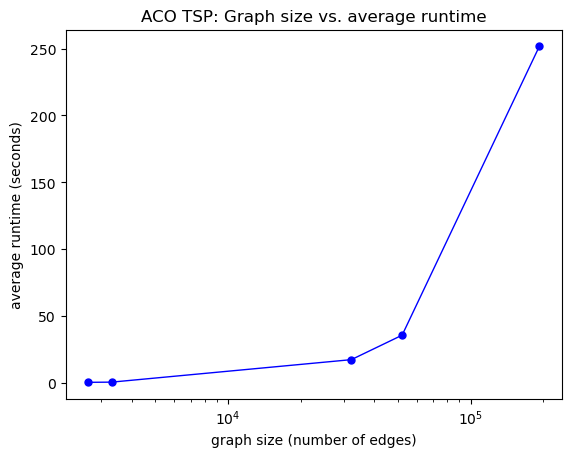

In [35]:
# Collect the graph sizes and average runtimes
sizes = [x.size() for x in list(results.keys())]
average_duration = [x[0] for x in list(results.values())]

# Plot the runtimes
plt.plot(sizes, average_duration, 'bo-', linewidth=1, markersize=5)
plt.xscale('log')
plt.xlabel('graph size (number of edges)')
plt.ylabel('average runtime (seconds)')
plt.title('ACO TSP: Graph size vs. average runtime')
plt.show()

#### Comments

The average runtime stays reasonable for smaller graphs, but quickly begins to grow with larger graphs. I would deduce that this is because the number of possible paths is not a linear function as you add edges - the difficulty of the problem increases quickly with more points to visit ways to get to those points.

## Question 3

### a) choose a dataset

I chose the [Openflights](https://networkrepository.com/inf-openflights.php) dataset, which shows flightpaths between certain airports. It has 2.9k nodes and 30.5k edges.

In [9]:
# Import the dataset
G = nx.read_edgelist('../inf-openflights.edges')

#### i) detect and visualize communities 

In [ ]:
# I chose to use Clauset-Newman-Moore greedy modularity maximization
communities = nx.community.greedy_modularity_communities(G)

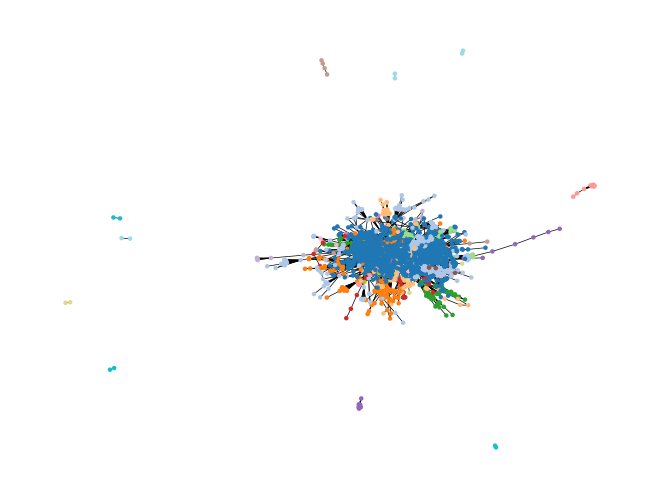

In [64]:
# Visualize the network

cnm_community_map = {}
for i, community in enumerate(communities):
    for node in community:
        cnm_community_map[node] = i

pos = nx.spring_layout(G)

colors = [cnm_community_map[node] for node in G.nodes]

# Draw nodes with color based on community
nx.draw(G, pos, node_color=colors, cmap=plt.cm.tab20, node_size=5, width=0.5)

#### ii) report the modularity

In [17]:
# Find modularity
print('Modularity: ' + str(nx.community.modularity(G, communities)))

Modularity: 0.5763241304374902


#### iii) report the number of communities

In [18]:
# Find number of communities
print('Number of communities: ' + str(len(communities)))

Number of communities: 60


#### iv) store partition as a dictionary (already done in (i))

In [19]:
# Store partition as a dictionary
cnm_community_map

{'870': 0,
 '474': 0,
 '826': 0,
 '1142': 0,
 '1108': 0,
 '422': 0,
 '371': 0,
 '692': 0,
 '751': 0,
 '612': 0,
 '1127': 0,
 '2106': 0,
 '2114': 0,
 '932': 0,
 '868': 0,
 '2739': 0,
 '858': 0,
 '391': 0,
 '1009': 0,
 '1118': 0,
 '1040': 0,
 '1044': 0,
 '696': 0,
 '641': 0,
 '61': 0,
 '425': 0,
 '749': 0,
 '891': 0,
 '789': 0,
 '536': 0,
 '935': 0,
 '418': 0,
 '616': 0,
 '527': 0,
 '341': 0,
 '550': 0,
 '475': 0,
 '2103': 0,
 '661': 0,
 '2773': 0,
 '871': 0,
 '727': 0,
 '2104': 0,
 '1205': 0,
 '1107': 0,
 '1140': 0,
 '627': 0,
 '793': 0,
 '1147': 0,
 '2035': 0,
 '1111': 0,
 '712': 0,
 '2116': 0,
 '700': 0,
 '563': 0,
 '65': 0,
 '799': 0,
 '1442': 0,
 '454': 0,
 '1437': 0,
 '2113': 0,
 '791': 0,
 '543': 0,
 '533': 0,
 '709': 0,
 '1514': 0,
 '483': 0,
 '502': 0,
 '1065': 0,
 '1446': 0,
 '435': 0,
 '58': 0,
 '220': 0,
 '1510': 0,
 '733': 0,
 '426': 0,
 '588': 0,
 '668': 0,
 '688': 0,
 '734': 0,
 '594': 0,
 '291': 0,
 '439': 0,
 '768': 0,
 '1498': 0,
 '606': 0,
 '1506': 0,
 '1083': 0,
 '150

### b) graph-tool

Before executing the code for this question, make sure you are using the `/courses/PHYS7332.202510/shared/graphtool/` custom environment.

In [20]:
import graph_tool.all as gt

In [33]:
# Convert nx graph to graph-tool graph
G_gt = gt.Graph(directed=False)
for u, v in G.edges():
    e = G_gt.add_edge(u, v)

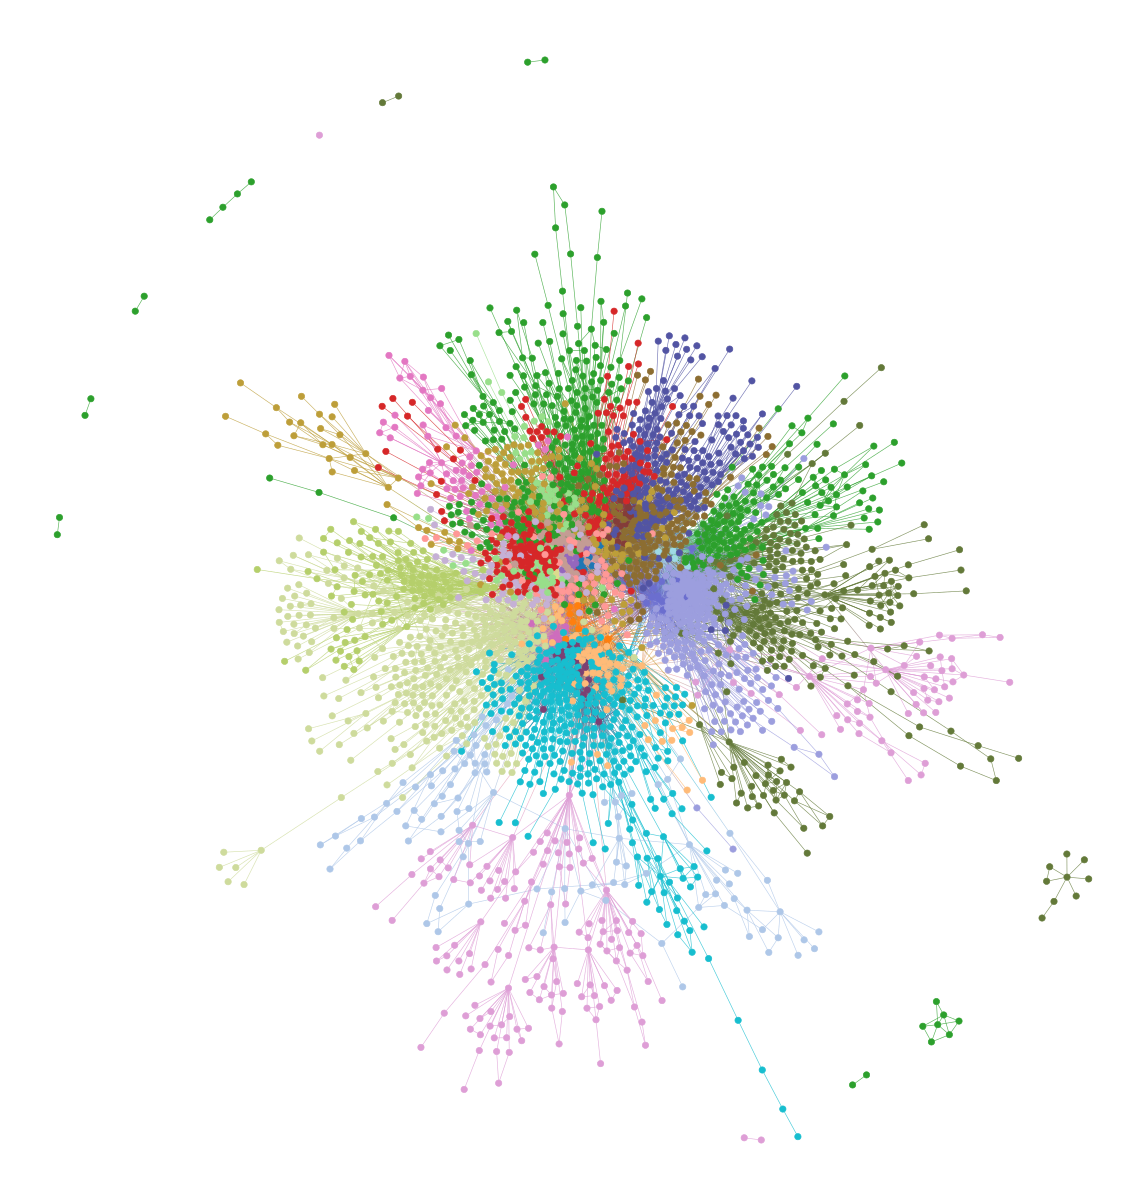

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x2ba83ff65df0, at 0x2ba83ff64c50>

In [36]:
# Detect communities
gt_partition = gt.minimize_blockmodel_dl(G_gt)

# Visualize the network
gt_partition.draw()

In [93]:
# Store partition as a dictionary

blocks = gt_partition.get_blocks() # get a mapping of the communities

# re-label the communities from 0..num_communities - 1
unique_blocks = np.unique(list(blocks))
block_mapping = {old_block: new_block for new_block, old_block in enumerate(unique_blocks)}


gt_community_map = {v: block_mapping[b] for v, b in enumerate(blocks)}
gt_community_map

{0: 41,
 1: 31,
 2: 31,
 3: 31,
 4: 31,
 5: 31,
 6: 31,
 7: 31,
 8: 31,
 9: 31,
 10: 31,
 11: 31,
 12: 28,
 13: 31,
 14: 28,
 15: 25,
 16: 31,
 17: 31,
 18: 31,
 19: 41,
 20: 31,
 21: 31,
 22: 31,
 23: 31,
 24: 31,
 25: 31,
 26: 31,
 27: 31,
 28: 31,
 29: 31,
 30: 31,
 31: 31,
 32: 31,
 33: 31,
 34: 36,
 35: 36,
 36: 36,
 37: 36,
 38: 36,
 39: 36,
 40: 36,
 41: 7,
 42: 36,
 43: 36,
 44: 36,
 45: 7,
 46: 36,
 47: 36,
 48: 36,
 49: 36,
 50: 36,
 51: 2,
 52: 16,
 53: 0,
 54: 36,
 55: 22,
 56: 22,
 57: 14,
 58: 10,
 59: 14,
 60: 20,
 61: 7,
 62: 20,
 63: 7,
 64: 13,
 65: 14,
 66: 40,
 67: 2,
 68: 3,
 69: 2,
 70: 39,
 71: 36,
 72: 23,
 73: 23,
 74: 23,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 4,
 84: 1,
 85: 1,
 86: 1,
 87: 1,
 88: 1,
 89: 23,
 90: 23,
 91: 23,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1,
 100: 1,
 101: 1,
 102: 1,
 103: 1,
 104: 1,
 105: 1,
 106: 1,
 107: 23,
 108: 1,
 109: 1,
 110: 1,
 111: 23,
 112: 23,
 113: 23,
 114: 1,
 1

### c) randomize the network

In [88]:
# Create a null model by randomly swapping edges while preserving degrees
G_null = nx.double_edge_swap(G, nswap=G.number_of_edges(), max_tries=200000)

# Convert nx graph to graph-tool graph
G_gt_null = gt.Graph(directed=False)
for u, v in G_null.edges():
    e = G_gt_null.add_edge(u, v)

In [91]:
# Clauset-Newman-Moore modularity maximization
G_null_communities = nx.community.greedy_modularity_communities(G_null)

# Store partition as a dictionary
G_null_community_map = {}
for i, community in enumerate(G_null_communities):
    for node in community:
        G_null_community_map[node] = i
        
G_null_community_map

{'1853': 0,
 '93': 0,
 '474': 0,
 '2927': 0,
 '2346': 0,
 '2490': 0,
 '422': 0,
 '1665': 0,
 '324': 0,
 '1256': 0,
 '612': 0,
 '771': 0,
 '2114': 0,
 '2350': 0,
 '932': 0,
 '868': 0,
 '1716': 0,
 '1315': 0,
 '391': 0,
 '2212': 0,
 '2678': 0,
 '1009': 0,
 '1118': 0,
 '835': 0,
 '927': 0,
 '1040': 0,
 '176': 0,
 '232': 0,
 '696': 0,
 '1915': 0,
 '1986': 0,
 '2805': 0,
 '1024': 0,
 '807': 0,
 '1254': 0,
 '2516': 0,
 '1489': 0,
 '536': 0,
 '2186': 0,
 '2767': 0,
 '616': 0,
 '1284': 0,
 '527': 0,
 '1914': 0,
 '341': 0,
 '229': 0,
 '1714': 0,
 '2103': 0,
 '1876': 0,
 '1205': 0,
 '2603': 0,
 '2790': 0,
 '627': 0,
 '2761': 0,
 '2709': 0,
 '2116': 0,
 '700': 0,
 '1490': 0,
 '65': 0,
 '799': 0,
 '1344': 0,
 '454': 0,
 '2113': 0,
 '2126': 0,
 '2856': 0,
 '502': 0,
 '2601': 0,
 '1065': 0,
 '435': 0,
 '122': 0,
 '2797': 0,
 '251': 0,
 '922': 0,
 '2144': 0,
 '2486': 0,
 '2524': 0,
 '2873': 0,
 '606': 0,
 '1898': 0,
 '1083': 0,
 '2630': 0,
 '1504': 0,
 '656': 0,
 '1494': 0,
 '2216': 0,
 '235': 0,
 '1

In [97]:
# graph-tool comminitiy detection
null_partition = gt.minimize_blockmodel_dl(G_gt_null)

# Store partition as a dictionary
blocks = null_partition.get_blocks() # get a mapping of the communities

# re-label the communities from 0..num_communities - 1
unique_blocks = np.unique(list(blocks))
print(unique_blocks)
block_mapping = {old_block: new_block for new_block, old_block in enumerate(unique_blocks)}

gt_null_community_map = {v: block_mapping[b] for v, b in enumerate(blocks)}

gt_null_community_map

[0]


{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,
 122: 0,
 12

### d) discussion

Yadda yadda yadda

In [23]:
impo

ModuleNotFoundError: No module named 'pandas'